<a href="https://colab.research.google.com/github/justinsydnor/GB894/blob/main/GB894_Autodata_InterpretableRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example lab on Permutation Importance.
Lab for General Business 894

Created by Professor Justin Sydnor

Last edited 5/24/2025

## Permutation Importance for Random Forest
This lab walks through an example of the Global Model Agnostic interpretability technique of "Permutation Importance".

We use an auto claims data set that was covered in the homework for Module 2.

We fit first a logistic regression and then a random forest. We use Permutation Importance to better understand the variables that affect the performance of the random forest and compare this to the standard Feature Importance metrics.

# Loading in the data

Load in the packages we might need (note this set is bigger than we need for this lab).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc, roc_auc_score


Next we load in our dataset from the class github repo

In [6]:
# Load in the auto data

url = "https://raw.githubusercontent.com/justinsydnor/GB894/refs/heads/main/autodata.csv"

df = pd.read_csv(url)
print(df.head())


   policyno    plcydate  clm_freq5  clm_amt5  clm_amt  kidsdriv  travtime  \
0       160  1997-11-08          2      4461        0         0        14   
1     24836  1998-07-29          0         0        0         0        22   
2     28046  1995-10-28          0         0        0         0        26   
3     28960  1994-06-11          2     38690        0         0         5   
4     40933  1993-09-20          0         0        0         0        32   

      car_use  bluebook  retained  ...  cartype_van redcar revolked  male  \
0     Private     14230        11  ...            0      1        0     1   
1  Commercial     14940         1  ...            0      1        0     1   
2     Private     21970         1  ...            1      1        0     1   
3     Private      4010         4  ...            0      0        0     0   
4     Private     15440         7  ...            0      1        0     1   

  married  singleparent  job_bluecollar  urban  homeowner probclaim  
0   

## Reduce the dataset to the variables of interest
To clean things up we start by reducing the dataset to key variables that we want to use for this analysis.

In [7]:
# prompt: Update the data frame to keep on the variables hadclaim commercial clm_freq5 clm_amt5 kidsdriv travtime redcar bluebook retained revolked mvr_pts age homekids male married urban homeowner yearsinhome job_bluecollar probclaim

df = df[['hadclaim', 'commercial', 'clm_freq5', 'clm_amt5', 'kidsdriv', 'travtime', 'redcar', 'bluebook', 'retained', 'revolked', 'mvr_pts', 'age', 'homekids', 'male', 'married', 'urban', 'homeowner', 'yearsinhome', 'job_bluecollar']]
print(df.head())

   hadclaim  commercial  clm_freq5  clm_amt5  kidsdriv  travtime  redcar  \
0         0           0          2      4461         0        14       1   
1         0           1          0         0         0        22       1   
2         0           0          0         0         0        26       1   
3         0           0          2     38690         0         5       0   
4         0           0          0         0         0        32       1   

   bluebook  retained  revolked  mvr_pts  age  homekids  male  married  urban  \
0     14230        11         0        3   60         0     1        0      1   
1     14940         1         0        0   43         0     1        0      1   
2     21970         1         0        2   48         0     1        0      1   
3      4010         4         0        3   35         1     0        1      1   
4     15440         7         0        0   51         0     1        1      1   

   homeowner  yearsinhome  job_bluecollar  
0          0

We can create a quick table so we understand average values for the variables in the data.

In [23]:
# create a table of the average values of the variables in the df

# Calculate the mean of each numeric column
average_values = df.mean(numeric_only=True)

# Convert the Series to a DataFrame for better display as a table
average_values_table = pd.DataFrame(average_values, columns=['Average Value'])

average_values_table


,Average Value
hadclaim,0.265534
commercial,0.370754
clm_freq5,0.800435
clm_amt5,4034.417046
kidsdriv,0.167150
travtime,33.462925
redcar,0.288422
bluebook,15676.792668
retained,5.336268
revolked,0.122618


## Create test and train datasets

In [8]:
train, test = train_test_split(df, test_size=0.25, random_state=32)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (7242, 19)
Test shape: (2414, 19)


Now get X and Xtest that exclude the outcome (hadclaim), the sensitive predictor (job_bluecollar)

In [9]:
X=train.drop(['hadclaim', 'job_bluecollar'], axis=1)
y=train['hadclaim']

Xtest=test.drop(['hadclaim', 'job_bluecollar'], axis=1)
ytest=test['hadclaim']

## Logistic regression
We begin by fitting a simple logistic regression on the data

In [10]:
# Create a logistic regression of y on the X

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Create and fit the logistic regression model
logit_mod_full = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_mod_full.summary())

Optimization terminated successfully.
         Current function value: 0.460054
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               hadclaim   No. Observations:                 7242
Model:                          Logit   Df Residuals:                     7224
Method:                           MLE   Df Model:                           17
Date:                Sat, 24 May 2025   Pseudo R-squ.:                  0.2066
Time:                        06:28:39   Log-Likelihood:                -3331.7
converged:                       True   LL-Null:                       -4199.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.6098      0.242    -10.789      0.000      -3.084      -2.136
commercial      0.9404    

## Let's get the predictions and confusion matrix
We are going to predict 1 when the probability from our logistic prediction model is greater than 0.6.

In [11]:
# get the predicted probabilities from the logit_mod_full in the dataset test

# Add a constant to the test predictor variables
Xtest = sm.add_constant(Xtest)

# Get the predicted probabilities for the test set
test['prob_full'] = logit_mod_full.predict(Xtest)

# Get the binary prediction based on predicted probability is greater than 0.6
test['predicted_full'] = np.where(test['prob_full'] > 0.6, 1, 0)

Let's look at the confusion matrix:

In [25]:
# show the confusion matrix on the test set

cm = confusion_matrix(ytest, test['predicted_full'])

# Wrap it in a labeled DataFrame
cm_df = pd.DataFrame(
    cm,
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

print("Confusion Matrix:")
cm_df

Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,1712,69
Actual 1,487,146


So we see that the algorithm is doing ok, but is only correctly predicting 146 of the 633 actual cases of having a claim in the dataset. The number of false positives is reasonably low, which corresponds to our decision to set a relatively high threshold for predicting.

### Accuracy measures
Now we want to know how accurate the model predictions were. We can consider a few different metrics. First, accuracy is just the share of correct predictions. Then we can also do the area under the receiver operating curve AUC. Finally, we can get the **average predicsion score**. This measure is useful when we have imbalanced data where the outcome is somewhat rare.

The Average Precision Score is a summary metric for the Precision-Recall (PR) curve. It captures how well a classifier identifies positive cases across different probability thresholds.

Precision = How many of the predicted positives are truly positive

Recall = How many of the actual positives were correctly identified

APS is the area under the Precision-Recall curve.


| Metric        | APS (PR Curve)                             | AUC (ROC Curve)                                                   |
| ------------- | ------------------------------------------ | ----------------------------------------------------------------- |
| Focuses on    | Positive class (precision + recall)        | Overall ranking of all classes                                    |
| Good for      | **Imbalanced data**                        | Balanced or general classification                                |
| Includes      | Only positives vs. predicted positives     | Both true positives and true negatives                            |
| Interprets as | Avg. precision across all recall levels    | Probability a random positive ranks higher than a random negative |
| Sensitive to  | How precise predictions are when confident | How well model separates classes                                  |


In [30]:
# Get measures of overall accuracy, AUC, and Average Precision Score

# Overall accuracy
accuracy_full = (test['predicted_full'] == test['hadclaim']).mean()
print(f"Accuracy_full model: {accuracy_full:.3f}")

# Calculate AUC
auc_full = roc_auc_score(test['hadclaim'], test['prob_full'])
print(f"AUC (Full model): {auc_full:.3f}")

from sklearn.metrics import average_precision_score

# Calculate Average Precision Score
aps_full = average_precision_score(test['hadclaim'], test['prob_full'])
print(f"Average Precision Score (Full model): {aps_full:.3f}")


Accuracy_full model: 0.770
AUC (Full model): 0.779
Average Precision Score (Full model): 0.554


So we see here for the logistic that we have an accuracy of 77%. That sounds ok, but note that since the overall likelihood of claims is only 26% if we simple never predicted positive, we would have an accuracy of 74%. The AUC looks similar. The Average Precision Score, though, is much lower, which reflects the fact that the model is not making that many correct predictions.

## Fitting our random forest model
We now want a more complex model so we can try out our interpretability approach.

We'll fit a random forest. To make sure the model isn't too big (and so our interpretability approach does not take too long to run) we limit to 100 trees and a max depth per tree of 10.

In [15]:
#rf = RandomForestClassifier(random_state=1)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
rf.fit(X, y)

RandomForestClassifier(max_depth=10, random_state=1)

We again get predicted probabilities from the algorithm and set our prediction classification based on that probability being greater than .6

In [26]:
# Predict probabilities and labels using the Random Forest model
test['prob_rf'] = rf.predict_proba(Xtest)[:, 1]                           # Predicted probability of claim
test['predicted_rf'] = np.where(test['prob_rf'] > 0.6, 1, 0)              # Binary prediction using same 0.6 threshold



Here we get the confusion matrix.

In [27]:
# show the confusion matrix on the test set

cm_rf = confusion_matrix(ytest, test['predicted_rf'])

# Wrap it in a labeled DataFrame
cm_rf_table = pd.DataFrame(
    cm_rf,
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

print("Confusion Matrix:")
cm_rf_table

Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,1748,33
Actual 1,556,77


We see that our random forest model is actually doing quite a bit worse at predicting positive cases, identifying only 77 of the actual cases of hadclaim.

## Accuracy measures for the Random Forest
Again we can get our three accuracy measures.

In [29]:


# Overall accuracy
accuracy_rf = (test['predicted_rf'] == test['hadclaim']).mean()
print(f"Accuracy_rf model: {accuracy_rf:.3f}")

# AUC
auc_rf = roc_auc_score(test['hadclaim'], test['prob_rf'])
print(f"AUC (RF model): {auc_rf:.3f}")

# Average Precision Score
aps_rf = average_precision_score(test['hadclaim'], test['prob_rf'])
print(f"Average Precision Score (RF model): {aps_rf:.3f}")



Accuracy_rf model: 0.756
AUC (RF model): 0.784
Average Precision Score (RF model): 0.547


We see here that compared to the logit model the Accuracy and Average Precision Score are both a little worse, while the AUC is actually a little higher.

## Model interpretability

Here we will compare the standard Feature Importance that you have seen before in Gen Bus 888 with Permutation Importance. Here is a table on the differences in the measures that I had ChatGPT help me create.

| Concept                  | Feature Importance (MDI - Mean Decrease in Impurity)                 | Permutation Importance                                              |
| ------------------------ | -------------------------------------------------------------------- | ------------------------------------------------------------------- |
| **What it measures**     | Total reduction in **Gini impurity** from all splits using a feature | Drop in model performance when a feature is randomly shuffled       |
| **How it's computed**    | During training, by tracking how much each feature improves splits   | After training, by evaluating model accuracy drop                   |
| **Model-dependent?**     | ✅ Yes — works only for tree-based models                             | ❌ No — works for any model                                          |
| **Handles correlation?** | ❌ No — may overstate importance of correlated features               | ✅ Yes — only shows drop if feature provides unique predictive value |
| **Bias risk**            | Can favor features with many levels or high cardinality              | More robust to feature type and distribution                        |


**Key distinction**

Gini-based feature importance tells you what the trees liked to split on.

Permutation importance tells you what the model truly needs to make accurate predictions.


We start with feature importance.

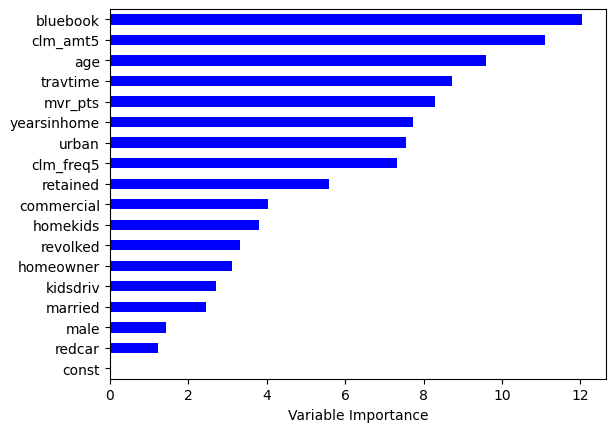

In [16]:
Importance_ = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X.columns)
Importance = Importance_.sort_values('Importance', axis=0, ascending=False)[0:20]
Importance.plot(kind='barh', color='b', ).invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

We see that according to feature importance, bluebook value of the car is the most "important" feature in our random forest, while amount of claims in the last five years is second most important.

So what do we get from permutation importance?

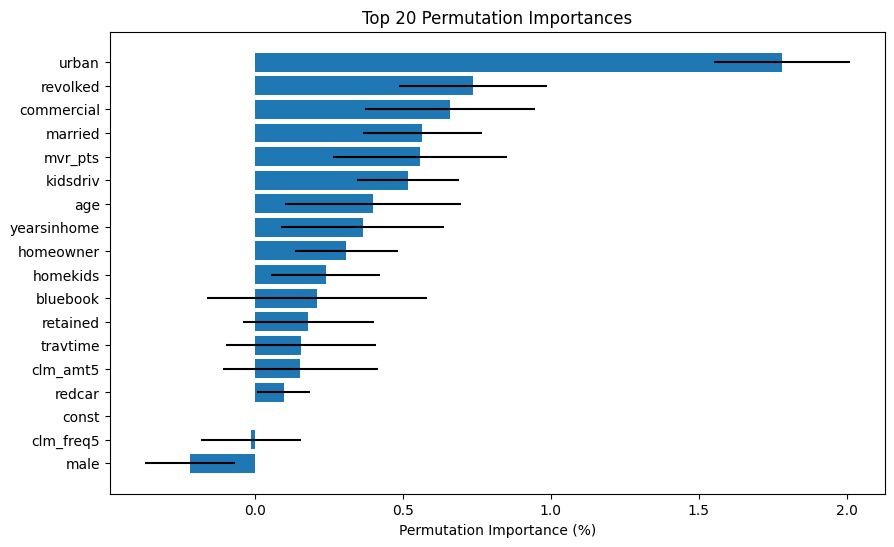

In [31]:

from sklearn.inspection import permutation_importance


# Run permutation importance
result = permutation_importance(rf, Xtest, ytest, n_repeats=30, random_state=42, n_jobs=-1)

# Create a DataFrame for easy handling
perm_importance = pd.DataFrame({
    'Feature': Xtest.columns,
    'Importance_Mean': result.importances_mean * 100,  # percent scale
    'Importance_Std': result.importances_std * 100
}).sort_values('Importance_Mean', ascending=False)

# Plot the top 20 most important features
top = perm_importance.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top['Feature'], top['Importance_Mean'], xerr=top['Importance_Std'])
plt.gca().invert_yaxis()
plt.xlabel('Permutation Importance (%)')
plt.title('Top 20 Permutation Importances')
plt.show()


We see that permutation importance tells us something very different. We now see that the feature urban is by far the most important driver of accurate predictions. We see that blue book value and claims in the past five years are actually not that important in our random forest.